In [1]:
import matplotlib
from datetime import datetime, timezone, timedelta
import pandas as pd
import math
from datetime import datetime
import numpy as np
import uuid
import pandas as pd
import os

import logging

logger = logging.getLogger(__name__)

from adlfs import AzureBlobFileSystem
import os

fs = AzureBlobFileSystem(account_name="unepazeconomyadlsstorage")
os.environ["AZURE_STORAGE_ACCOUNT"] = "unepazeconomyadlsstorage"
os.environ["AZURE_STORAGE_ANON"] = "true"

os.makedirs("figures", exist_ok=True)

# https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

C0 = "#648FFF"
C1 = "#785EF0"
C2 = "#DC267F"
C3 = "#FE6100"
C4 = "#FFB000" # #FFB000

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
from marss2l import loaders

dataframe_data_traintest = loaders.read_csv(add_columns_for_analysis=True, fs=fs)

In [3]:
mlis_df = dataframe_data_traintest[dataframe_data_traintest.location_name == "MYS_1"].copy().sort_values("tile_date")
mlis_df.shape

(310, 52)

In [4]:
def isplumestr(mli) -> str:
    if (mli.observability is not None) and (mli.observability != "clear"):
        return "cloudy/bad retrieval"
    
    if mli.observability is None:
        raise ValueError("Observability must be defined")
        # if mli.too_much_clouds(threshold_max_noclear=threshold_max_noclear):
        #     return "cloudy/bad retrieval"
    
    if (mli.isplume is None):
        return "not validated"
    elif mli.isplume:
        return "yes"
    else:
        return "no"
        

In [5]:
mlis_df["isplumestr"] = mlis_df.apply(lambda row: isplumestr(row), axis=1)
mlis_df.loc[mlis_df.isplumestr == "no", ["ch4_fluxrate", "ch4_fluxrate_std"]] = 0
mlis_df.loc[mlis_df.isplumestr == "cloudy/bad retrieval", ["ch4_fluxrate", "ch4_fluxrate_std"]] = pd.NA

# mlis_df["isnotified"] = ~mlis_df.id_incident.isna()
mlis_df["isplumestr"].value_counts()

isplumestr
cloudy/bad retrieval    129
no                      109
yes                      72
Name: count, dtype: int64

In [6]:
mlis_df["isplumestr"].value_counts().sum()

np.int64(310)

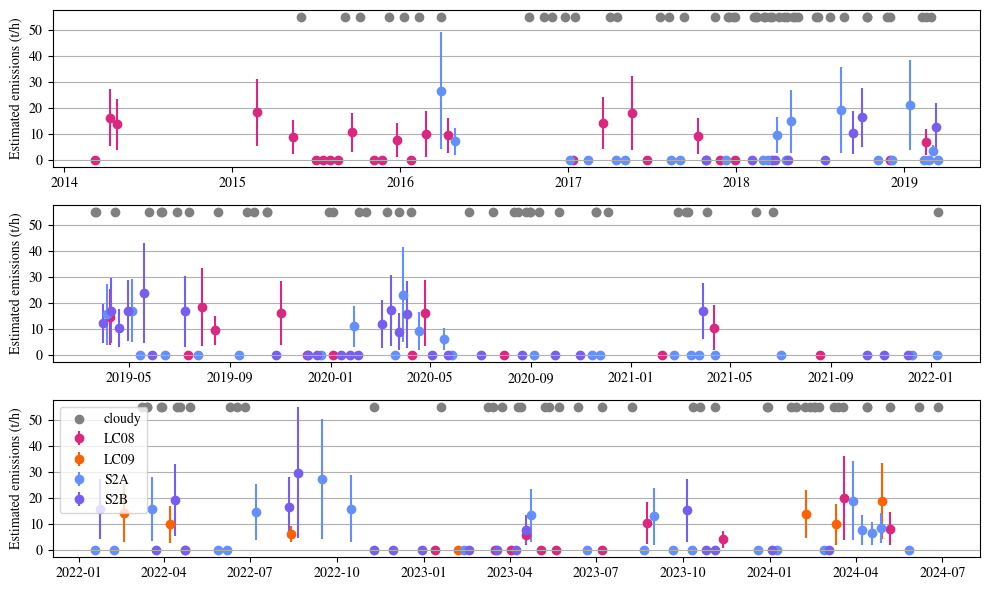

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timezone

# mlis_df.isplumestr = mlis_df.apply(lambda row: "unknown" if row. is None else "plume" if x else "no plume", axis=1)

COLOR_SATELLITE = {
    "S2A": C0,
    "S2B": C1,
    "LC08": C2,
    "LC09": C3,
    "PRISMA": C4
}
# Define a function to plot each subset to avoid code duplication
def plot_subset(df, ax, plot_legend:bool=False):
    df_positive = df[(df.isplumestr == "yes") & (df.ch4_fluxrate > 0)]
    df_negative = df[(df.isplumestr == "no")]
    df_nonobservable = df[df.isplumestr == "cloudy/bad retrieval"]

    for i, (satame, data) in enumerate(df_positive.groupby("satellite")):
        ax.errorbar(data.tile_date, data.ch4_fluxrate/1000,
                    yerr=2*data.ch4_fluxrate_std/1000,
                    fmt="o", label=satame, color=COLOR_SATELLITE[satame])
        data_neg = df_negative[df_negative.satellite == satame]
        ax.scatter(data_neg.tile_date, data_neg.ch4_fluxrate.values, 
                   color=COLOR_SATELLITE[satame])
    ax.scatter(df_nonobservable.tile_date, 55+np.zeros_like(df_nonobservable.ch4_fluxrate.values),
               label="cloudy", color="gray")
    if plot_legend:
        ax.legend(loc="upper left")
    ax.grid(axis="y")
    ax.set_yticks([0, 10, 20, 30, 40, 50])
    ax.set_ylabel("Estimated emissions (t/h)")

nsplits = 3  # Or any number you want
# Calculate the size of each split
mlis_df_val = mlis_df[mlis_df.isplumestr != "not validated"]
split_size = len(mlis_df_val) // nsplits

width = 10
height = 2


# fig, ax = plt.subplots(2,1,figsize=(16,8),tight_layout=True)
fig, ax = plt.subplots(nsplits,1,figsize=(width,nsplits*height),tight_layout=True)
for i in range(nsplits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < nsplits - 1 else len(mlis_df_val)
    plot_subset(mlis_df_val.iloc[start_idx:end_idx], ax[i], i == nsplits-1)

plt.savefig("figures/malaysia_offshore_UNEP_IMEO_complete_ts.pdf")